# Gaussian Naive Bayes

## Introduction

Expanding Bayes theorem to account for multiple observations and conditional probabilities drastically increases predictive power. In essence, it allows you to develop a belief network taking into account all of the available information regarding the scenario. In this lesson, you'll take a look at one particular implementation of a multinomial naive Bayes algorithm: Gaussian Naive Bayes.

## Objectives

You will be able to:

* Explain the Gaussian Naive Bayes algorithm
* Implement the Gaussian Naive Bayes (GNB) algorithm using SciPy and NumPy

## Theoretical background

Multinomial Bayes expands upon Bayes' theorem to multiple observations.

Recall that Bayes' theorem is:  

$$ \Large P(A|B) = \frac{P(B|A)\bullet P(A)}{P(B)}$$

Expanding to multiple features, the multinomial Bayes' formula is:  

$$ \Large P(y|x_1, x_2, ..., x_n) = \frac{P(y)\prod_{i}^{n}P(x_i|y)}{P(x_1, x_2, ..., x_n)}$$


Here $y$ is an observation class while $x_1$ through $x_n$ are various features of the observation. Similar to linear regression, these features are assumed to be linearly independent. The motivating idea is that the various features $x_1, x_2,...x_n$ will help inform which class a particular observation belongs to. This could be anything from 'Does this person have a disease?' to 'Is this credit card purchase fraudulent' or 'What marketing audience does this individual fall into?'. In this lesson you will work with classic iris dataset. This dataset includes various measurements of a flower's anatomy and the specific species of the flower. For that dataset, $y$ would be the flower species while $x_1$ through $x_n$ would be the various measurements for a given flower. As such, the equation for Multinomial Bayes, given above, would allow you to calculate the probability that a given flower belongs to a specific category of species.

With that, let's dig into the formula a little more to get a deeper understanding. In the numerator, you multiply the product of the conditional probabilities $P(x_i|y)$ by the probability of the class y. The denominator is the overall probability (across all classes) for the observed values of the various features. In practice, this can be difficult or impossible to calculate. Fortunately, doing so is typically not required, as you will simply be comparing the relative probabilities of the various classes&mdash;do you believe this flower is of species A, species B or species C?  

To calculate each of the conditional probabilities in the numerator, $P(x_i|y)$, the Gaussian Naive Bayes algorithm traditionally uses the Gaussian probability density function to give a relative estimate of the probability of the feature observation, $x_i$, for the class $y$. Some statisticians don't agree with this as the probability of any point on a PDF curve is actually 0. As you've seen in z-tests and t-tests, only ranges of values have a probability, and these are calculated by taking the area under the PDF curve for the given range. While true, these point estimates can be loosely used as 'the relative probability for values near $x_i$'. 

With that, you have:  

$$\Large P(x_i|y) = \frac{1}{\sqrt{2\pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$

Where $\mu_i$ is the mean of feature $x_i$ for class $y$ and $\sigma_i^2$ is the variance of feature $x_i$ for class $y$.

From there, each of the relative posterior probabilities are calculated for each of the classes. The largest of these is the class which is the most probable for the given observation.  

With that, let's take a look in practice to try to make this process a little clearer.



## Load the dataset

First, let's load in the Iris dataset to use to demonstrate the Gaussian Naive Bayes algorithm: 

In [36]:
from sklearn import datasets
import pandas as pd
import numpy as np

iris = datasets.load_iris()

X = pd.DataFrame(iris.data)
X.columns = iris.feature_names

y = pd.DataFrame(iris.target)
y.columns = ['Target']

df = pd.concat([X, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [37]:
print(iris.keys())
print(type(iris))
print(iris['target_names'])
print(iris.target_names)
print(iris.values())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
<class 'sklearn.utils.Bunch'>
['setosa' 'versicolor' 'virginica']
['setosa' 'versicolor' 'virginica']
dict_values([array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 

It's always a good idea to briefly examine the data. In this case, let's check how many observations there are for each flower species:

In [38]:
df['Target'].value_counts()

2    50
1    50
0    50
Name: Target, dtype: int64

## Calculate the mean and standard deviation of each feature for each class

Next, you calculate the mean and standard deviation within a class for each of the features. You'll then use these values to calculate the conditional probability of a particular feature observation for each of the classes.

In [39]:
aggs = df.groupby('Target').agg(['mean', 'std'])
aggs

sepal length (cm)           sepal width (cm)            \
                    mean       std             mean       std   
Target                                                          
0                  5.006  0.352490            3.428  0.379064   
1                  5.936  0.516171            2.770  0.313798   
2                  6.588  0.635880            2.974  0.322497   

       petal length (cm)           petal width (cm)            
                    mean       std             mean       std  
Target                                                         
0                  1.462  0.173664            0.246  0.105386  
1                  4.260  0.469911            1.326  0.197753  
2                  5.552  0.551895            2.026  0.274650

In [40]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [41]:
aggs.describe()

sepal length (cm)           sepal width (cm)            \
                   mean       std             mean       std   
count          3.000000  3.000000         3.000000  3.000000   
mean           5.843333  0.501513         3.057333  0.338453   
std            0.795061  0.142262         0.336822  0.035438   
min            5.006000  0.352490         2.770000  0.313798   
25%            5.471000  0.434330         2.872000  0.318147   
50%            5.936000  0.516171         2.974000  0.322497   
75%            6.262000  0.576025         3.201000  0.350781   
max            6.588000  0.635880         3.428000  0.379064   

      petal length (cm)           petal width (cm)            
                   mean       std             mean       std  
count            3.0000  3.000000         3.000000  3.000000  
mean             3.7580  0.398490         1.199333  0.192596  
std              2.0907  0.198973         0.896735  0.084750  
min              1.4620  0.173664         0.246000  0.105386  
25%              2.8610  0.321787         0.786000  0.151569  
50%              4.2600  0.469911         1.326000  0.197753  
75%              4.9060  0.510903         1.676000  0.236201  
max              5.5520  0.551895         2.026000  0.274650

In [42]:
df.shape

(150, 5)

In [43]:
aggs.shape

(3, 8)

## Calculate conditional probability point estimates

Take another look at how to implement point estimates for the conditional probabilities of a feature for a given class. To do this, you'll simply use the PDF of the normal distribution. (Again, there can be some objection to this method as the probability of a specific point for a continuous distribution is 0. Some statisticians bin the continuous distribution into a discrete approximation to remedy this, but doing so requires additional work and the width of these bins is an arbitrary value which will potentially impact results.)

$$ \Large P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$


In [45]:
from scipy import stats

def p_x_given_class(obs_row, feature, class_):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]
    
    # A single observation
    obs = df.iloc[obs_row][feature] 
    
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

# Notice how this is not a true probability; you can get values > 1
p_x_given_class(0, 'petal length (cm)', 0) 

2.1553774365786804

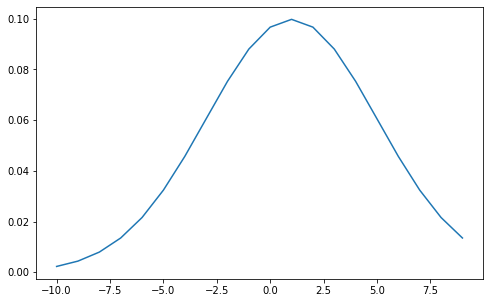

0.09973557010035818

In [46]:
xlist=[]
y=[]
for x in range(-10,10):
    xlist.append(x)
    y.append(stats.norm.pdf(x, loc=1, scale=4))
    
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(xlist,y)
plt.show()
max(y)

In [47]:
p_x_given_class(obs_row=0, feature = 'petal length (cm)', class_ =0)
p_x_given_class(obs_row=0, feature = 'petal length (cm)', class_ =1)
p_x_given_class(obs_row=0, feature = 'petal length (cm)', class_ =2)
p_x_given_class(obs_row=1, feature = 'petal length (cm)', class_ =0)
df.iloc[0]['petal length (cm)'] 
df.iloc[1]['petal length (cm)'] 

1.4

## Multinomial Bayes

In [68]:
row = 100
c_probs = []
for c in range(3):
    # Initialize probability to relative probability of class 
    p = len(df[df['Target'] == c])/len(df) 
    for feature in X.columns:
        p *= p_x_given_class(row, feature, c) 
        # Update the probability using the point estimate for each feature
    c_probs.append(p)

c_probs

[9.529514999027405e-251, 2.460149009916488e-12, 0.023861042537402642]

In [69]:
df.iloc[100]

sepal length (cm)     6.3
sepal width (cm)      3.3
petal length (cm)       6
petal width (cm)      2.5
Target                  2
Predictions             2
Correct?             True
Name: 100, dtype: object

In [70]:
row = 40
c_probs = []
for c in range(3):
    # Initialize probability to relative probability of class 
    p = len(df[df['Target'] == c])/len(df) 
    for feature in X.columns:
        p *= p_x_given_class(row, feature, c) 
        # Update the probability using the point estimate for each feature
    c_probs.append(p)

c_probs

[1.9244207134225062, 2.5029671494064887e-17, 1.0887773437674585e-24]

In [71]:
df.iloc[40]

sepal length (cm)       5
sepal width (cm)      3.5
petal length (cm)     1.3
petal width (cm)      0.3
Target                  0
Predictions             0
Correct?             True
Name: 40, dtype: object

In [72]:
df[df['Target']== 1]
len(df)

150

In [73]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [74]:

X


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Calculating class probabilities for observations

While you haven't even attempted to calculate the denominator for the original equation,  

$$P(y|x_1,x_2,...x_n) = \frac{P(y)\prod_{i}^{n}P(x_i|y)}{P(x_1,x_2,...x_n)}$$ 

you don't really have to.  

That is, the probability $P(x_1, x_2, ..., x_n)$ is the probability of the given observation across all classes; it is not a function of class at all. As such, it will be a constant across all of these posterior class probabilities. Since you are simply interested in the most likely class for each observation, you can simply pick the class with the largest numerator. With that, let's adapt the code snippet above to create a function which predicts a class for a given row of data.

In [75]:
def predict_class(row):
    c_probs = []
    for c in range(3):
        # Initialize probability to relative probability of class
        p = len(df[df['Target'] == c])/len(df) 
        for feature in X.columns:
            p *= p_x_given_class(row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

Let's also take an example row to test this new function: 

In [76]:
row = 0
df.iloc[row]

sepal length (cm)     5.1
sepal width (cm)      3.5
petal length (cm)     1.4
petal width (cm)      0.2
Target                  0
Predictions             0
Correct?             True
Name: 0, dtype: object

In [77]:
predict_class(row)

0

In [78]:
row=0
c_probs = []
for c in range(3):
    # Initialize probability to relative probability of class
    p = len(df[df['Target'] == c])/len(df) 
    for feature in X.columns:
        p *= p_x_given_class(row, feature, c)
    c_probs.append(p)
c_probs

[2.7915339171768885, 8.322426199968082e-18, 6.008422572011136e-25]

Nice! It appears that this `predict_class()` function has correctly predicted the class for this first row! Now it's time to take a look at how accurate this function is across the entire dataset!

## Calculating accuracy

In order to determine the overall accuracy of your newly minted Gaussian Naive Bayes classifier, you'll need to generate predictions for all of the rows in the dataset. From there, you can then compare these predictions to the actual class values stored in the 'Target' column. Take a look:

In [79]:
df['Predictions'] =  [predict_class(row) for row in df.index]
df['Correct?'] = df['Target'] == df['Predictions']
df['Correct?'].value_counts(normalize=True)

True     0.96
False    0.04
Name: Correct?, dtype: float64

In [80]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target,Predictions,Correct?
0,5.1,3.5,1.4,0.2,0,0,True
1,4.9,3.0,1.4,0.2,0,0,True
2,4.7,3.2,1.3,0.2,0,0,True
3,4.6,3.1,1.5,0.2,0,0,True
4,5.0,3.6,1.4,0.2,0,0,True
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2,True
146,6.3,2.5,5.0,1.9,2,2,True
147,6.5,3.0,5.2,2.0,2,2,True
148,6.2,3.4,5.4,2.3,2,2,True


## Summary

Nicely done! You're well on your way to using Bayesian statistics in the context of machine learning! In this lesson, you saw how to adapt Bayes theorem along with your knowledge of the normal distribution to create a machine learning classifier known as Gaussian Naive Bayes. 